# Exploration des données et nettoyage

In [246]:
import polars as pl
import matplotlib.pyplot as plt

df = pl.read_csv("../datasets/chunks.csv")

In [247]:
print(df.head(5))

shape: (5, 4)
┌──────┬──────┬─────────────────────────────────┬─────────────────────────────────┐
│ year ┆ page ┆ category                        ┆ chunk                           │
│ ---  ┆ ---  ┆ ---                             ┆ ---                             │
│ i64  ┆ i64  ┆ str                             ┆ str                             │
╞══════╪══════╪═════════════════════════════════╪═════════════════════════════════╡
│ 2024 ┆ 2    ┆ RAPPORT D'ACTIVITÉS             ┆ RAPPORT D'ACTIVITÉS > LA RICHE… │
│ 2024 ┆ 3    ┆ RAPPORT D'ACTIVITÉS             ┆ RAPPORT D'ACTIVITÉS > MICHEL L… │
│ 2024 ┆ 3    ┆ ATTRACTIVITÉ & DÉVELOPPEMENT É… ┆ ATTRACTIVITÉ & DÉVELOPPEMENT É… │
│ 2024 ┆ 3    ┆ ATTRACTIVITÉ & DÉVELOPPEMENT É… ┆ ATTRACTIVITÉ & DÉVELOPPEMENT É… │
│ 2024 ┆ 3    ┆ ATTRACTIVITÉ & DÉVELOPPEMENT É… ┆ ATTRACTIVITÉ & DÉVELOPPEMENT É… │
└──────┴──────┴─────────────────────────────────┴─────────────────────────────────┘


### Détection des doublons

In [248]:
print(len(df))
df = df.unique()
print(len(df))

2128
1931


### Répartition du nombre de caractères/mots par chunk

In [249]:
df = df.with_columns(
    pl.col("chunk").map_elements(lambda x: len(x), return_dtype=pl.Int64).alias("nb_char"),
    pl.col("chunk").map_elements(lambda x: len(x.split(' ')), return_dtype=pl.Int64).alias("nb_words")
)

#### Detection des outliers

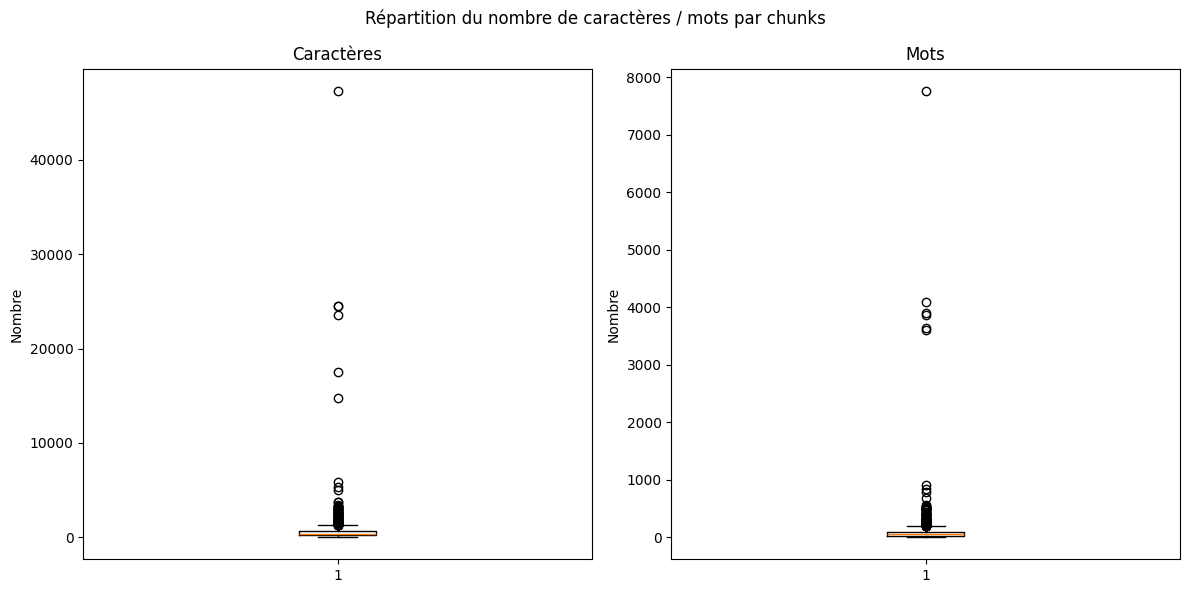

In [250]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].boxplot(df["nb_char"])
axes[0].set_title("Caractères")
axes[0].set_ylabel("Nombre")

axes[1].boxplot(df["nb_words"])
axes[1].set_title("Mots")
axes[1].set_ylabel("Nombre")

plt.suptitle("Répartition du nombre de caractères / mots par chunks")
plt.tight_layout()
plt.show()

On supprime donc les chunks qui ont plus de 10.000 caractères ou plus de 1.000 mots.

In [251]:
print(len(df))
df = df.filter((pl.col("nb_char") < 1000) & (pl.col("nb_words") < 150))
print(len(df))

1931
1683


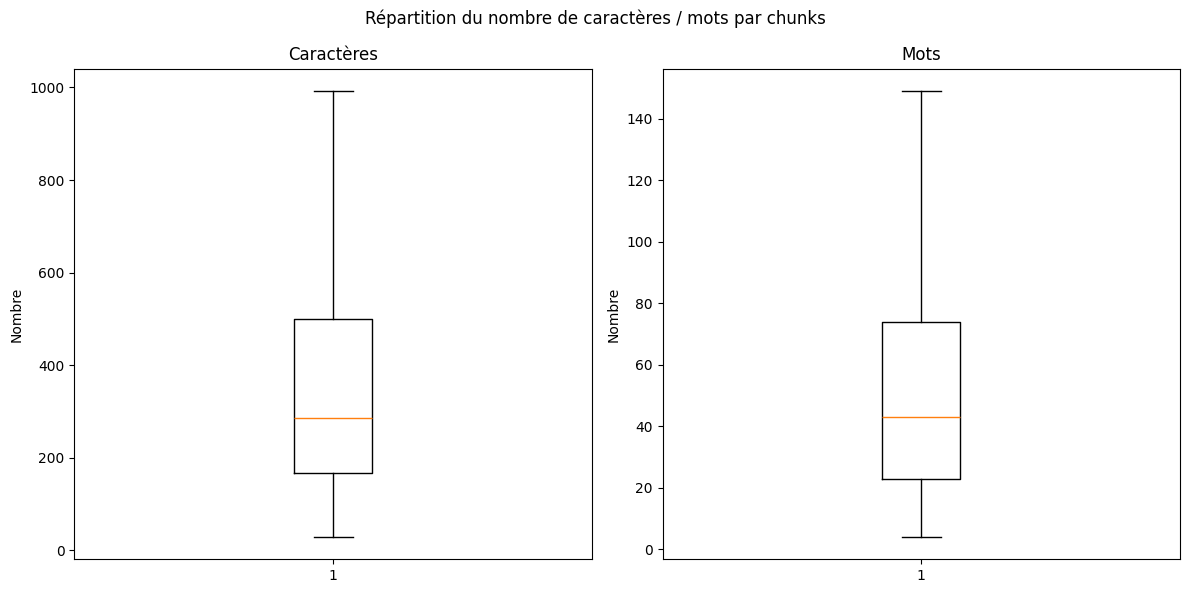

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].boxplot(df["nb_char"])
axes[0].set_title("Caractères")
axes[0].set_ylabel("Nombre")

axes[1].boxplot(df["nb_words"])
axes[1].set_title("Mots")
axes[1].set_ylabel("Nombre")

plt.suptitle("Répartition du nombre de caractères / mots par chunks")
plt.tight_layout()
plt.show()

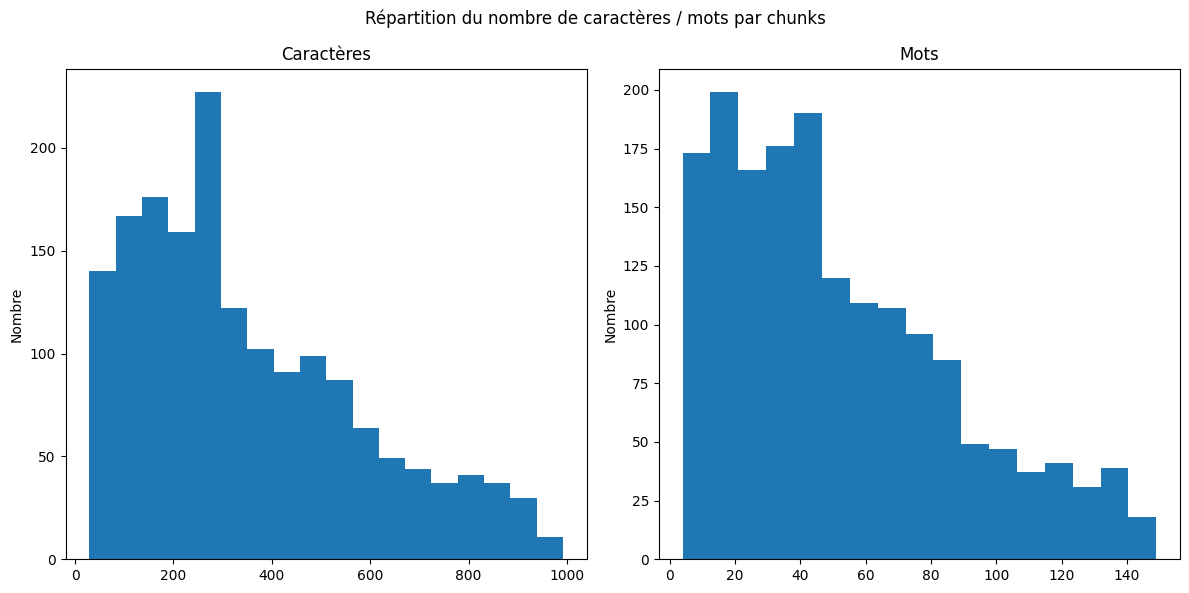

In [253]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(df["nb_char"], bins="auto")
axes[0].set_title("Caractères")
axes[0].set_ylabel("Nombre")

axes[1].hist(df["nb_words"], bins="auto")
axes[1].set_title("Mots")
axes[1].set_ylabel("Nombre")

plt.suptitle("Répartition du nombre de caractères / mots par chunks")
plt.tight_layout()
plt.show()

### Répartition du nombre de chunks/caractères/mots par année

In [254]:
yearly_avg = df.group_by("year").agg([
    pl.col("nb_char").mean().alias("avg_nb_char"),
    pl.col("nb_words").mean().alias("avg_nb_words"),
]).sort("year")

print(yearly_avg)

shape: (16, 3)
┌──────┬─────────────┬──────────────┐
│ year ┆ avg_nb_char ┆ avg_nb_words │
│ ---  ┆ ---         ┆ ---          │
│ i64  ┆ f64         ┆ f64          │
╞══════╪═════════════╪══════════════╡
│ 2009 ┆ 324.824742  ┆ 48.494845    │
│ 2010 ┆ 280.319328  ┆ 40.537815    │
│ 2011 ┆ 351.578947  ┆ 51.27193     │
│ 2012 ┆ 344.571429  ┆ 53.671958    │
│ 2013 ┆ 346.675     ┆ 52.441667    │
│ …    ┆ …           ┆ …            │
│ 2020 ┆ 260.976471  ┆ 36.141176    │
│ 2021 ┆ 290.5625    ┆ 42.635417    │
│ 2022 ┆ 272.495935  ┆ 40.276423    │
│ 2023 ┆ 412.990196  ┆ 61.431373    │
│ 2024 ┆ 390.88      ┆ 59.04        │
└──────┴─────────────┴──────────────┘


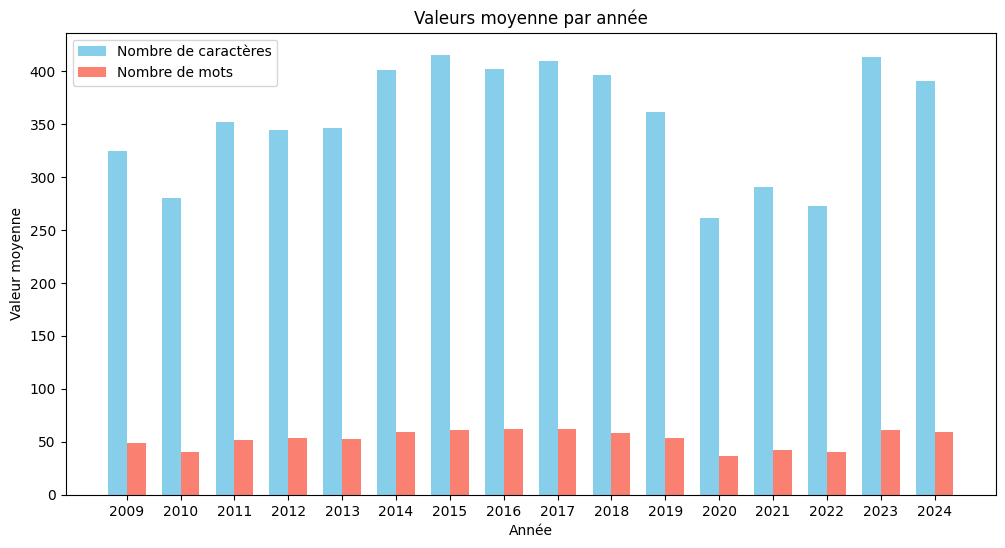

In [255]:
fig, axes = plt.subplots(figsize=(12, 6))

x = list(range(len(yearly_avg["year"])))
width = 0.35

plt.bar([i - width/2 for i in x], yearly_avg["avg_nb_char"], width=width, label="Nombre de caractères", color="skyblue")
plt.bar([i + width/2 for i in x], yearly_avg["avg_nb_words"], width=width, label="Nombre de mots", color="salmon")

plt.xlabel("Année")
plt.ylabel("Valeur moyenne")
plt.title("Valeurs moyenne par année")
plt.xticks(x, yearly_avg["year"].to_list())
plt.legend()
plt.show()

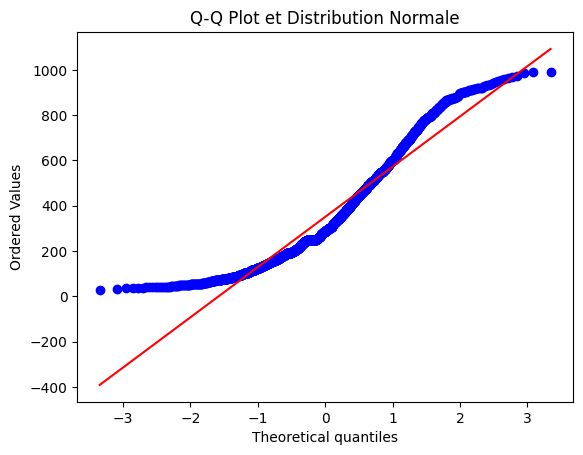

In [256]:
import scipy.stats as stats

stats.probplot(df["nb_char"], dist="norm", plot=plt)

plt.title("Q-Q Plot et Distribution Normale")
plt.show()
### Relation entre nombre de pages et nombre de chunks par année

### Relation entre nombre de pages et nombre de chunks par année

In [257]:
yearly_sums = df.group_by("year").agg([
    pl.col("page").max().alias("nb_page"),
    pl.count().alias("nb_chunks")
])

print(yearly_sums)

shape: (16, 3)
┌──────┬─────────┬───────────┐
│ year ┆ nb_page ┆ nb_chunks │
│ ---  ┆ ---     ┆ ---       │
│ i64  ┆ i64     ┆ u32       │
╞══════╪═════════╪═══════════╡
│ 2019 ┆ 42      ┆ 103       │
│ 2013 ┆ 35      ┆ 120       │
│ 2015 ┆ 37      ┆ 103       │
│ 2011 ┆ 35      ┆ 114       │
│ 2010 ┆ 35      ┆ 119       │
│ …    ┆ …       ┆ …         │
│ 2009 ┆ 37      ┆ 97        │
│ 2016 ┆ 20      ┆ 60        │
│ 2012 ┆ 33      ┆ 189       │
│ 2022 ┆ 26      ┆ 123       │
│ 2020 ┆ 26      ┆ 85        │
└──────┴─────────┴───────────┘


C:\Users\nicol\AppData\Local\Temp\ipykernel_29352\403108502.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("nb_chunks")


In [258]:
print(yearly_sums.select(pl.corr("nb_page", "nb_chunks")))

shape: (1, 1)
┌──────────┐
│ nb_page  │
│ ---      │
│ f64      │
╞══════════╡
│ 0.153468 │
└──────────┘


### Comptage des mots les plus fréquents

In [259]:
import spacy

nlp = spacy.blank("fr")
stop_words = nlp.Defaults.stop_words

In [260]:
words = (
    df.select(
        pl.col("chunk")
        .str.replace_all(r"[^\w\s]", "")
        .str.to_lowercase()
        .str.split(" ")
        .alias("words")
    )
    .explode("words")
)

print(words)

shape: (87_903, 1)
┌─────────────┐
│ words       │
│ ---         │
│ str         │
╞═════════════╡
│ bâtiments   │
│             │
│ copropriété │
│ les         │
│ tilleuls    │
│ …           │
│ roots       │
│ of          │
│ the         │
│ equation    │
│ 411a        │
└─────────────┘


In [261]:
words_clean = words.filter(
    (~pl.col("words").is_in(stop_words)) & (pl.col("words").str.len_chars() > 5)
)

print(words_clean)

shape: (38_177, 1)
┌─────────────┐
│ words       │
│ ---         │
│ str         │
╞═════════════╡
│ bâtiments   │
│ copropriété │
│ tilleuls    │
│ uckange     │
│             │
│ relogement  │
│ …           │
│ 16          │
│ where       │
│             │
│ number      │
│ equation    │
│ number      │
│ equation    │
└─────────────┘


In [262]:
word_counts = words_clean.group_by("words").agg(
    pl.count().alias("count")
).sort("count", descending=True).head(30)
print(word_counts)

shape: (30, 2)
┌─────────────┬───────┐
│ words       ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ travaux     ┆ 388   │
│ nombre      ┆ 299   │
│ fensch      ┆ 294   │
│ number      ┆ 266   │
│ territoire  ┆ 261   │
│ …           ┆ …     │
│ services    ┆ 127   │
│ culture     ┆ 124   │
│ réalisation ┆ 116   │
│ marquants   ┆ 116   │
│             ┆       │
│ maîtrise    ┆ 115   │
└─────────────┴───────┘


C:\Users\nicol\AppData\Local\Temp\ipykernel_29352\3207109033.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count")


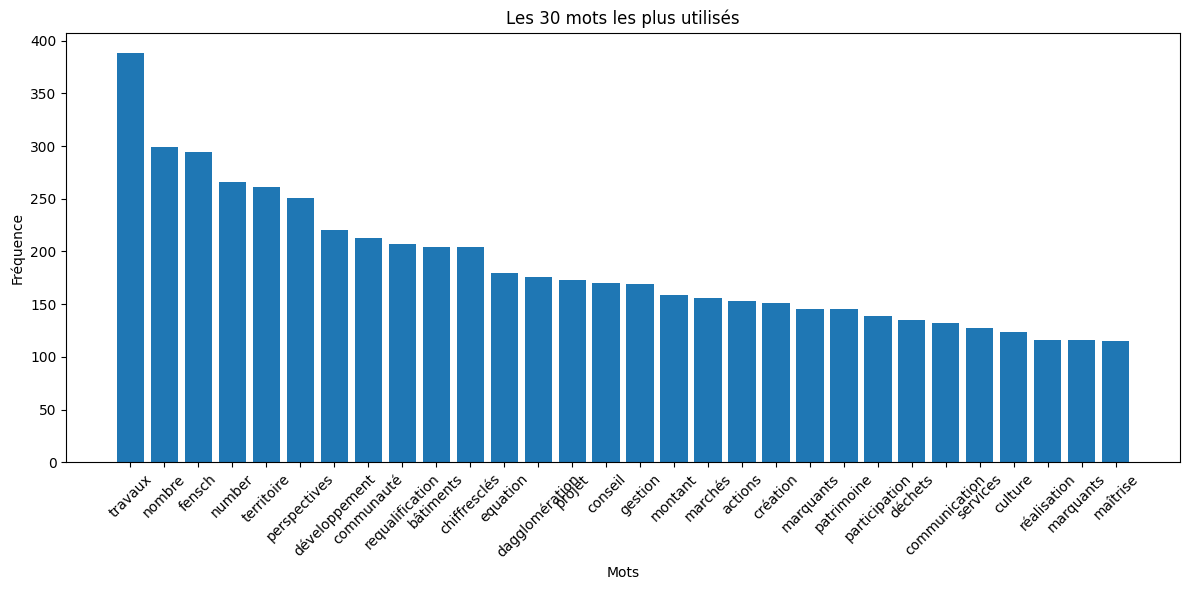

In [263]:
plt.figure(figsize=(12, 6)) 
plt.bar(word_counts["words"], word_counts["count"])
plt.xticks(rotation=45)
plt.title('Les 30 mots les plus utilisés')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.tight_layout() 
plt.show()

### Thèmes les plus fréquents

In [264]:
theme_frequency = df.group_by("category").agg(
    pl.count().alias("nb_chunks")
).sort("nb_chunks", descending=True)

print(theme_frequency)

shape: (150, 2)
┌─────────────────────────────────┬───────────┐
│ category                        ┆ nb_chunks │
│ ---                             ┆ ---       │
│ str                             ┆ u32       │
╞═════════════════════════════════╪═══════════╡
│ SOLUTIONS                       ┆ 109       │
│ Bâtiments                       ┆ 107       │
│ Sommaire                        ┆ 82        │
│ Marchés publics                 ┆ 65        │
│ La communauté d'agglomération … ┆ 45        │
│ …                               ┆ …         │
│ Le sommaire                     ┆ 1         │
│ Juridique                       ┆ 1         │
│ LABELSPORT                      ┆ 1         │
│ Chiffres clés 2009              ┆ 1         │
│ Le mot du Président             ┆ 1         │
└─────────────────────────────────┴───────────┘


C:\Users\nicol\AppData\Local\Temp\ipykernel_29352\825514038.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("nb_chunks")


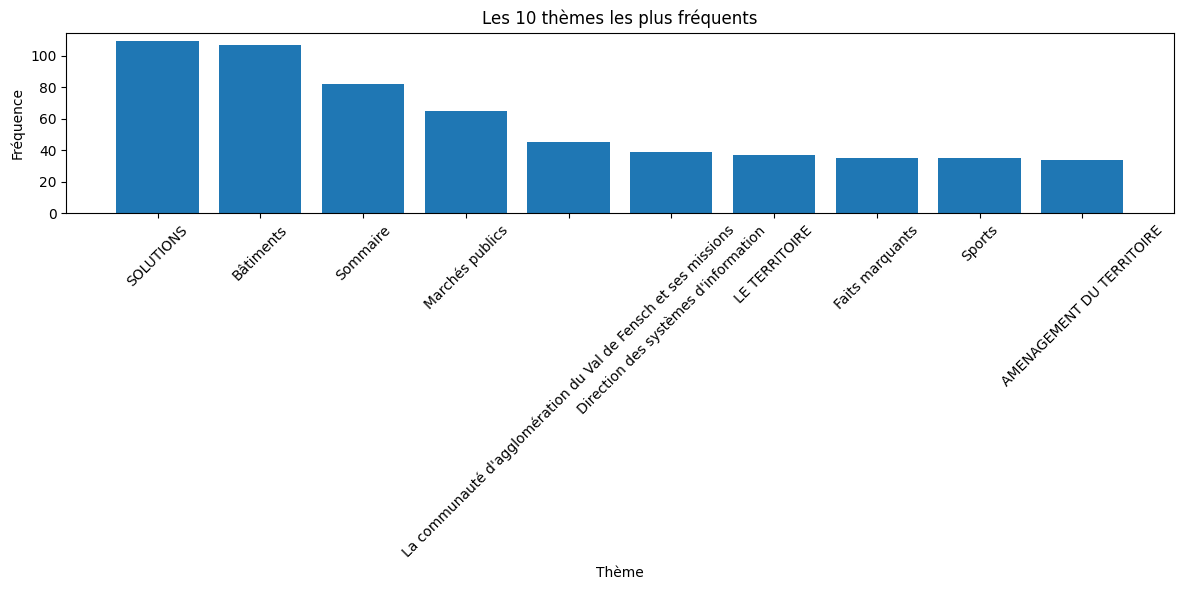

In [265]:
plt.figure(figsize=(12, 6)) 
plt.bar(theme_frequency.head(10)["category"], theme_frequency.head(10)["nb_chunks"])
plt.xticks(rotation=45)
plt.title('Les 10 thèmes les plus fréquents')
plt.xlabel('Thème')
plt.ylabel('Fréquence')
plt.tight_layout() 
plt.show()

Suppression des thèmes avec moins de 3 chunks

In [266]:
category_to_clear = theme_frequency.filter(pl.col("nb_chunks") < 5)

print(len(df))
df = df.filter(~pl.col("category").is_in(category_to_clear["category"]))
print(len(df))

1683
1534


C:\Users\nicol\AppData\Local\Temp\ipykernel_29352\1761653039.py:4: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df = df.filter(~pl.col("category").is_in(category_to_clear["category"]))


## Sauvegarde du nouveau dataframe

In [270]:
df = df.drop(["nb_char", "nb_words"])
df.write_csv("../datasets/chunks_cleaned.csv")